In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tickers = ['AAPL','MSFT','IBM']
p = get_pricing(tickers,'2006-01-01','2011-01-01')

In [3]:
def calc_signals(tickers,p,a,b):
    sma = p['price'].rolling(a).mean()
    smb = p['price'].rolling(b).mean()
    signal = np.sign(sma - smb).diff()
    actual_signals = signal[signal!=0].dropna(how='all',axis=0)
    for col in actual_signals.columns:
        idx = actual_signals[col].first_valid_index()
        signal[col][idx] = signal[col][idx]/2

    return signal

sig = calc_signals(tickers,p,10,20)



In [4]:
def calc_pnl(sig,p):
    return (sig*p['price']).sum()
    
calc_pnl(sig,p).sum()

301.3079999999999

In [5]:
def optimize(tickers,p,vals,N):
    pnls = []
    for i in range(N):
        a = min(vals[i])
        b = max(vals[i])
        try:
            sig = calc_signals(tickers,p,a,b)
            pnls.append(calc_pnl(sig,p).sum())
        except:
            pnls.append(np.nan)
    return pnls

#N = 1000
#vals = np.array([np.random.randint(10,100,(N,)),np.random.randint(10,100,(N,))]).T
#pnls = optimize(tickers,p,vals,N)
#plt.hist(pnls,40)

In [122]:
N = 1000
sm = 15
lm = 90
vals = np.array([np.random.randint(5,90,(N,)) for i in range(2)]).T
p = get_pricing(tickers,'2008-01-01','2011-01-01')
pnls1 = optimize(tickers,p,vals,N)
p = get_pricing(tickers,'2011-01-01','2013-05-01')
pnls2 = optimize(tickers,p,vals,N)

print len(pnls1),len(pnls2)

1000 1000


In [123]:
def remove_nans(pnls1,pnls2,vals):
    idx1 = ~np.isnan(pnls1)
    pnls1 = np.array(pnls1)[idx1]
    pnls2 = np.array(pnls2)[idx1]
    vals = np.array(vals)[idx1]
    idx2 = ~np.isnan(pnls2)
    pnls1 = np.array(pnls1)[idx2]
    pnls2 = np.array(pnls2)[idx2]
    vals = np.array(vals)[idx2]
    return pnls1,pnls2,vals

In [134]:
from sklearn.cluster import KMeans
pnls1,pnls2,vals = remove_nans(pnls1,pnls2,vals)
kmeans = KMeans(n_clusters=3, random_state=5).fit(np.array([pnls1,pnls2]).T)



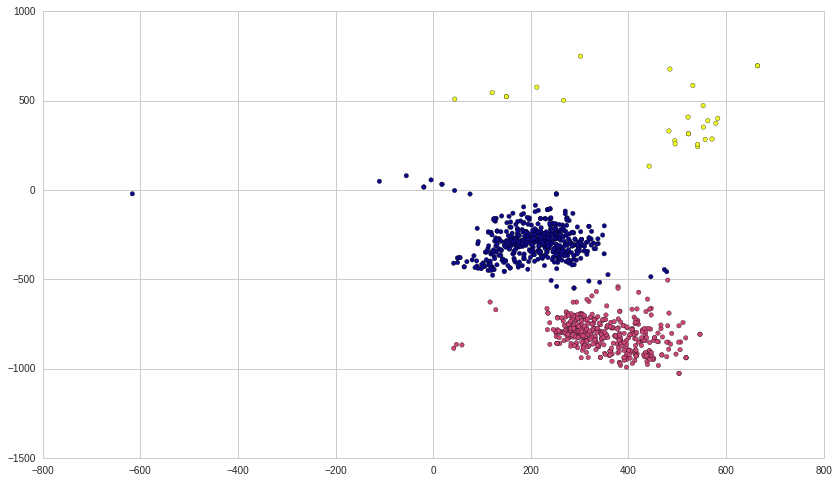

In [135]:
plt.scatter(pnls1,pnls2,c=kmeans.labels_,cmap='plasma')

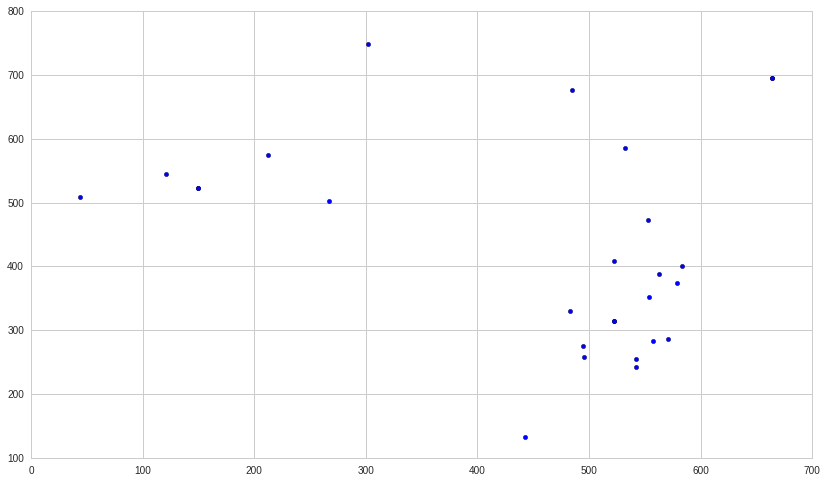

In [140]:

plt.scatter(pnls1[kmeans.labels_==2],pnls2[kmeans.labels_==2])

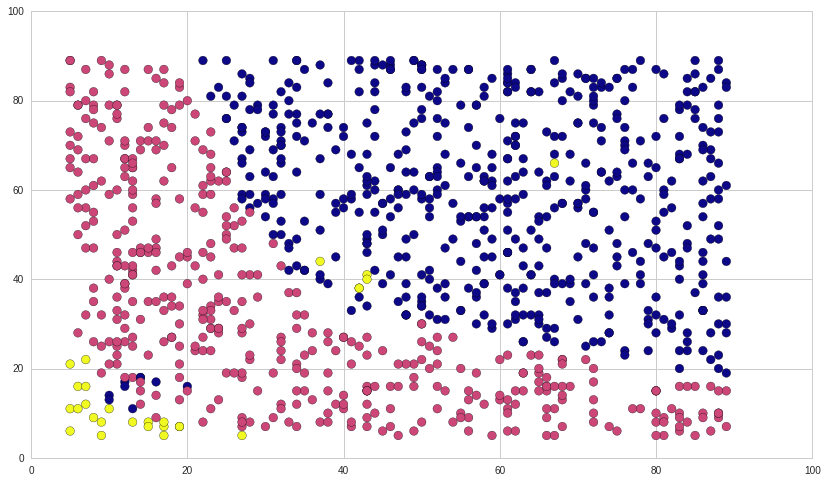

In [141]:
plt.scatter(np.array(vals)[:,0],np.array(vals)[:,1],c=kmeans.labels_,cmap='plasma',s=75)
